# Grid Search Minimization

This notebook illustrate the steps for a grid search minimization of the output quantile.

#### Libraries

In [7]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

random_state = 123
np.random.seed(random_state)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Model function
This example consider the simple additive example.

In [12]:
from dependence.tests import func_overflow, margins_overflow, var_names_overflow, func_sum

test_func = func_sum

#### Dimension and margins
We first define the problem dimension and the margins

In [13]:
if test_func == func_overflow:
    margins = margins_overflow
    dim = len(margins)
else:
    dim = 2
    margins = [ot.Normal()]*dim

We chose the coefficients of the variables throught the additive function.

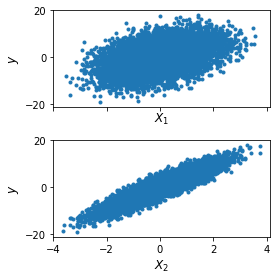

In [15]:
if test_func == func_sum:
    coeficients = np.logspace(0., 1., dim+1, endpoint=False)[1:]

    n_plot = 10000
    x = np.asarray(ot.ComposedDistribution(margins).getSample(n_plot))
    y = test_func(x, coeficients)

    fig, axes = plt.subplots(dim, 1, sharex=True, sharey=True, figsize=(4, 2*dim))
    for i in range(dim):
        ax = axes[i]
        ax.plot(x[:, i], y, '.')
        ax.set_xlabel(r'$X_%d$' % (i+1), fontsize=12)
        ax.set_ylabel(r'$y$', fontsize=12)
    fig.tight_layout()

#### Copula families
We now consider only Gaussian dependencies for this example

In [16]:
families = np.zeros((dim, dim), dtype=int)
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1

## Estimations
We create an instance of the main class for conservative estimate, and we define a q_func object for the quantile as a quantity of interest

In [17]:
from dependence import ConservativeEstimate, quantile_func

alpha = 0.99

if alpha > 0.5: # Maximizing the quantile
    def q_func(x, axis=1):
        return - quantile_func(alpha)(x, axis=axis)
else: # Minimizing
    q_func = quantile_func(alpha)

quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)

First, we compute the quantile at independence

In [18]:
n = 10000
indep_result = quant_estimate.independence(n_input_sample=n, q_func=q_func, random_state=random_state)

In [19]:
indep_result.compute_bootstrap(1000)
boot_std = indep_result.bootstrap_sample.std()
boot_mean = indep_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: -3.38 with a C.O.V at 1.4 %


### Grid Search Approach
Firstly, we consider a grid search approach in order to compare the perfomance with the iterative algorithm.

In [25]:
K = 100
grid_type = 'rand'
quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)
grid_result = quant_estimate.gridsearch_minimize(n_dep_param=K, n_input_sample=n, grid_type=grid_type, 
                                                 q_func=q_func, random_state=random_state)

In [26]:
min_result = grid_result.min_result
min_result.compute_bootstrap(1000)
boot_std = min_result.bootstrap_sample.std()
boot_mean = min_result.bootstrap_sample.mean()
print('Worst Quantile: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))
print('Cost = %d' % (K*n))

Worst Quantile: -4.70 with a C.O.V at 2.4 %
Cost = 1000000


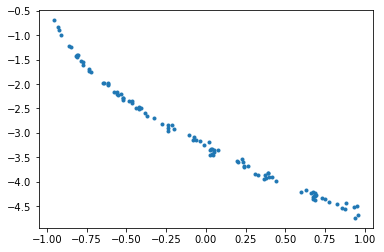

In [28]:
if dim == 2:
    fig, ax = plt.subplots()
    ax.plot(grid_result.dep_params, grid_result.quantities, '.')

In [30]:
quant_estimate.params_

AttributeError: 'ConservativeEstimate' object has no attribute '_params'

In [29]:
a = grid_result[0]
a